In this project, I read the following kernel:

https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101#Evaluation

The main RecSys techniques are:

Collaborative Filtering: This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.

Content-Based Filtering: This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.

# Import packages and load data.

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

For the sake of simplicity, we only consider here the "CONTENT SHARED" event type, assuming (naively) that all articles were available during the whole one year period.

In [2]:
articles_df = pd.read_csv('/Users/rileychiu/Desktop/deskdrop/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [3]:
interactions_df = pd.read_csv('/Users/rileychiu/Desktop/deskdrop/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [4]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

Recommender systems have a problem known as user cold-start, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.
For this reason, we are keeping in the dataset only users with at leas 10 interactions.

In [5]:
users_interactions_count_df = interactions_df.groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 10].reset_index()[['personId']]
print('# users with at least 10 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 10 interactions: 949


In [6]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 10 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 10 interactions: 68524


In [7]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 37926


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


# Evaluation

In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

In [8]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 30340
# interactions on Test set: 7586


In [9]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.
This evaluation method works as follows:

For each user:

For each item the user has interacted in test set:

Sample 100 other items the user has never interacted.
Ps. Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.

Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items

Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list

Aggregate the global Top-N accuracy metrics

The Top-N accuracy metric choosen was Recall@N which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

Recall=(recommend intersect interacted)/interacted

Recall at k is the proportion of relevant items found in the top-k recommendations

Suppose that we computed recall at 10 and found it is 40% in our top-10 recommendation system. This means that 40% of the total number of the relevant items appear in the top-k results.

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

In [10]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [11]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        precision_at_5 = hits_at_5_count/101
        precision_at_10 = hits_at_10_count/101

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'precision@5': precision_at_5,
                          'precision@10':precision_at_10}
        return person_metrics
    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_precision_at_5 = detailed_results_df['hits@5_count'].sum() / (101*len(interactions_test_indexed_df.index.unique()))
        global_precision_at_10 = detailed_results_df['hits@10_count'].sum() / (101*len(interactions_test_indexed_df.index.unique()))
        
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'precision@5': global_precision_at_5,
                          'precision@10': global_precision_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

# Popularity model

In [12]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,285.863434
1,-133139342397538859,214.269680
2,-6783772548752091658,212.007270
3,-8208801367848627943,190.107608
4,-6843047699859121724,188.410170
5,8224860111193157980,187.445559
6,2581138407738454418,174.282876
7,-2358756719610361882,173.941026
8,7507067965574797372,172.509040
9,3367026768872537336,162.939312


In [13]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]
        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [14]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
947 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.24677036646453995, 'recall@10': 0.38083311363037176, 'precision@5': 0.019551322220829677, 'precision@10': 0.030172954004261187}


,_person_id,hits@10_count,hits@5_count,interacted_count,precision@10,precision@5,recall@10,recall@5
3,3609194402293569455,45,26,192,0.445545,0.257426,0.234375,0.135417
5,-2626634673110551643,30,14,134,0.297030,0.138614,0.223881,0.104478
37,-1032019229384696495,28,12,130,0.277228,0.118812,0.215385,0.092308
89,-1443636648652872475,17,6,117,0.168317,0.059406,0.145299,0.051282
200,-2979881261169775358,31,23,87,0.306931,0.227723,0.356322,0.264368
121,-3596626804281480007,18,13,80,0.178218,0.128713,0.225000,0.162500
127,1116121227607581999,18,8,73,0.178218,0.079208,0.246575,0.109589
80,692689608292948411,18,14,69,0.178218,0.138614,0.260870,0.202899
116,3636910968448833585,32,21,68,0.316832,0.207921,0.470588,0.308824
104,-9016528795238256703,26,15,68,0.257426,0.148515,0.382353,0.220588


# Content-Based Filtering model

In [15]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [16]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [17]:
user_profiles = build_users_profiles()
len(user_profiles)

949

In [18]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


In [19]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [20]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
947 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.43000263643553915, 'recall@10': 0.5346691273398365, 'precision@5': 0.03406859673309103, 'precision@10': 0.042361198145130965}


,_person_id,hits@10_count,hits@5_count,interacted_count,precision@10,precision@5,recall@10,recall@5
3,3609194402293569455,25,15,192,0.247525,0.148515,0.130208,0.078125
5,-2626634673110551643,30,13,134,0.297030,0.128713,0.223881,0.097015
37,-1032019229384696495,36,20,130,0.356436,0.198020,0.276923,0.153846
89,-1443636648652872475,57,41,117,0.564356,0.405941,0.487179,0.350427
200,-2979881261169775358,17,11,87,0.168317,0.108911,0.195402,0.126437
121,-3596626804281480007,27,19,80,0.267327,0.188119,0.337500,0.237500
127,1116121227607581999,11,3,73,0.108911,0.029703,0.150685,0.041096
80,692689608292948411,23,17,69,0.227723,0.168317,0.333333,0.246377
116,3636910968448833585,9,4,68,0.089109,0.039604,0.132353,0.058824
104,-9016528795238256703,17,10,68,0.168317,0.099010,0.250000,0.147059


# Collaborative Filtering model

In [21]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9109785559521267180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180,
 -9060214117327732109]

In [24]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [25]:
U.shape

(949, 15)

In [26]:
Vt.shape

(15, 2933)

In [27]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [28]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.04239031,  0.0008807 ,  0.01225532, ..., -0.01590902,
        -0.00310311, -0.00271164],
       [ 0.00718358,  0.00748234, -0.01501065, ..., -0.01689828,
        -0.00369596,  0.01090595],
       [ 0.02172282,  0.00027781,  0.00585874, ...,  0.00053862,
        -0.00375026,  0.00300554],
       ...,
       [-0.02749938,  0.00613331, -0.0301241 , ..., -0.03862674,
        -0.00188554,  0.01523204],
       [-0.02651425,  0.00084792,  0.02506398, ..., -0.00776269,
         0.00516115, -0.01689742],
       [-0.02111173, -0.00109385,  0.15840137, ..., -0.0558295 ,
         0.03173557,  0.02190565]])

In [29]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,-9060214117327732109,...,9102085903669288476,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.042390,0.007184,0.021723,-0.010762,0.001325,0.011603,0.051796,-0.015273,0.004398,-0.001038,...,0.044255,-0.004637,-0.028743,0.003642,0.005009,-0.001472,-0.027778,-0.027499,-0.026514,-0.021112
-9216926795620865886,0.000881,0.007482,0.000278,-0.000505,0.000553,0.000355,0.000883,-0.000650,0.003010,0.000097,...,-0.000298,0.001903,0.013378,0.000167,0.000696,0.008339,0.000899,0.006133,0.000848,-0.001094
-9194572880052200111,0.012255,-0.015011,0.005859,0.028180,0.000821,0.028659,-0.015218,-0.017560,0.015087,-0.006885,...,-0.006691,0.004277,0.036837,0.004882,0.024364,0.147745,0.017941,-0.030124,0.025064,0.158401
-9192549002213406534,0.020014,-0.004314,-0.007215,0.023871,-0.000737,0.014883,0.040538,0.009572,-0.002032,-0.013772,...,-0.004392,-0.006671,0.174971,0.002558,-0.000142,0.043061,0.014262,-0.003465,0.030838,0.102175
-9190737901804729417,0.002898,0.005858,0.000592,-0.000404,0.000235,0.000644,0.000260,-0.000211,0.005017,-0.000280,...,0.001010,0.001272,0.014423,0.000139,0.000048,0.001243,0.001038,0.006060,0.001626,-0.002482
-9189659052158407108,0.025061,0.003186,-0.002692,0.005258,0.001853,0.000855,0.018287,0.028799,0.003002,0.003587,...,-0.001910,0.016023,0.050675,0.000177,0.000173,0.095995,0.008093,0.012076,0.013978,0.038864
-9184137057748005562,0.001760,0.003935,0.000089,-0.000263,0.000330,0.000632,-0.000184,0.000512,0.003389,0.000526,...,-0.000284,0.000878,0.010947,-0.000223,-0.000589,-0.003847,0.000340,0.004369,0.001487,-0.000878
-9176143510534135851,0.031526,0.019330,0.000523,-0.006001,-0.001163,0.004800,0.017766,0.084287,0.040455,0.023444,...,0.000655,0.010236,0.107691,-0.006547,-0.004320,-0.008847,-0.000208,0.056074,0.016221,-0.012184
-9172673334835262304,0.000305,0.002076,-0.000402,0.000506,-0.000003,0.000731,0.003484,-0.005040,0.001426,-0.002147,...,0.000230,0.002130,0.006407,-0.000095,-0.000096,0.000024,0.002031,-0.000522,0.002588,-0.000774


In [30]:
len(cf_preds_df.columns)

949

In [31]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [32]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
947 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3377273925652518, 'recall@10': 0.471658317954126, 'precision@5': 0.026757739065045746, 'precision@10': 0.03736892676609433}


,_person_id,hits@10_count,hits@5_count,interacted_count,precision@10,precision@5,recall@10,recall@5
3,3609194402293569455,47,20,192,0.465347,0.198020,0.244792,0.104167
5,-2626634673110551643,42,28,134,0.415842,0.277228,0.313433,0.208955
37,-1032019229384696495,32,21,130,0.316832,0.207921,0.246154,0.161538
89,-1443636648652872475,49,35,117,0.485149,0.346535,0.418803,0.299145
200,-2979881261169775358,38,24,87,0.376238,0.237624,0.436782,0.275862
121,-3596626804281480007,31,23,80,0.306931,0.227723,0.387500,0.287500
127,1116121227607581999,37,22,73,0.366337,0.217822,0.506849,0.301370
80,692689608292948411,31,28,69,0.306931,0.277228,0.449275,0.405797
116,3636910968448833585,23,19,68,0.227723,0.188119,0.338235,0.279412
104,-9016528795238256703,29,16,68,0.287129,0.158416,0.426471,0.235294


# Hybrid Recommender

In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.
Let's build a simple hybridization method, by only add the CF score with the Content-Based score, and ranking by resulting score.

In [33]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] + recs_df['recStrengthCF'])/2
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

In [34]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
947 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.4831268125494332, 'recall@10': 0.5705246506722911, 'precision@5': 0.03827756193340853, 'precision@10': 0.04520198855328571}


,_person_id,hits@10_count,hits@5_count,interacted_count,precision@10,precision@5,recall@10,recall@5
3,3609194402293569455,37,25,192,0.366337,0.247525,0.192708,0.130208
5,-2626634673110551643,42,23,134,0.415842,0.227723,0.313433,0.171642
37,-1032019229384696495,32,28,130,0.316832,0.277228,0.246154,0.215385
89,-1443636648652872475,49,43,117,0.485149,0.425743,0.418803,0.367521
200,-2979881261169775358,32,21,87,0.316832,0.207921,0.367816,0.241379
121,-3596626804281480007,33,25,80,0.326733,0.247525,0.412500,0.312500
127,1116121227607581999,24,17,73,0.237624,0.168317,0.328767,0.232877
80,692689608292948411,30,22,69,0.297030,0.217822,0.434783,0.318841
116,3636910968448833585,21,13,68,0.207921,0.128713,0.308824,0.191176
104,-9016528795238256703,25,20,68,0.247525,0.198020,0.367647,0.294118


# Comparing the methods

In [35]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,precision@10,precision@5,recall@10,recall@5
modelName,,,,
Popularity,0.030173,0.019551,0.380833,0.246770
Collaborative Filtering,0.037369,0.026758,0.471658,0.337727
Content-Based,0.042361,0.034069,0.534669,0.430003
Hybrid,0.045202,0.038278,0.570525,0.483127


Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a Recall@5 of 48% and Recall@10 of 57%

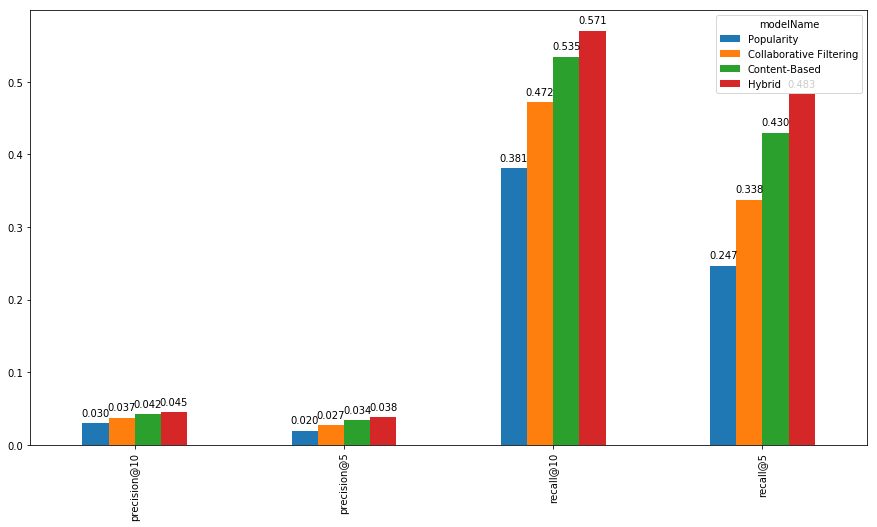

In [36]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Conclusion

In this notebook, we've explored and compared the main Recommender Systems techniques on CI&T Deskdrop dataset. It could be observed that for articles recommendation, content-based filtering and a hybrid method performed better than Collaborative Filtering alone.